In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import os
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
import matplotlib.image as img
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models


In [ ]:
NUM_CLASSES = 4
IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 15
EARLY_STOP_PATIENCE = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 16
BATCH_SIZE_VALIDATION = 16

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [ ]:
### 
### Below systax is available with TensorFlow 1.11 onwards but this upgrade is not available for Kaggle kernel yet
###
import tensorflow as tf
print(tf.__version__)
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

2.4.1


In [ ]:
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = 256

# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence

data_generator = ImageDataGenerator(rescale = 1./255,
                                    validation_split = 0.2,
                                  preprocessing_function=preprocess_input)


# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders

train_generator = data_generator.flow_from_directory(
        directory= 'drive/MyDrive/DOPTRAIN',
        shuffle = True,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode ='categorical',
        subset = "training")

validation_generator = data_generator.flow_from_directory(
        directory= 'drive/MyDrive/DOPTRAIN',
        shuffle = True,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical',
        subset= 'validation') 





Found 3415 images belonging to 4 classes.
Found 850 images belonging to 4 classes.


In [ ]:
test_generator = data_generator.flow_from_directory(
        directory= 'drive/MyDrive/four_classes/test',
        shuffle = False,
        target_size=(image_size, image_size),
        batch_size=1,
        class_mode ='categorical'
        )



Found 241 images belonging to 4 classes.


In [ ]:
#from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import keras
mobnet = MobileNet(include_top=False, weights='imagenet', input_shape=(256,256,3))
output = mobnet.layers[-1].output
output = keras.layers.Flatten()(output)
mobnet = Model(mobnet.input, output)
for layer in mobnet.layers:
    layer.trainable = False
mobnet.summary()

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
# # we use SGD with a low learning rate
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(mobnet)
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_dim=256))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer=Nadam(lr=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


In [ ]:
history = model.fit_generator(train_generator,
                    steps_per_epoch = train_generator.n// 16,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // 16,
                    epochs=50)

In [ ]:
'''resnet = MobileNet(weights='imagenet', include_top=False)
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256,kernel_regularizer=regularizers.l2(0.001),activation='sigmoid')(x)
x = Dropout(0.5)(x)

predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=resnet.input, outputs=predictions)

# # we use SGD with a low learning rate
from keras.optimizers import Nadam
from keras.optimizers import Adam
model.compile(optimizer=Nadam(lr=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit_generator(train_generator,
                    steps_per_epoch = train_generator.n// 16,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // 16,
                    epochs=20,
                    )

model.save('model_trained_3class.hdf5')'''

17227776/17225924 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
213/213 [==============================] - 1405s 7s/step - loss: 1.1357 - accuracy: 0.7069 - val_loss: 3.4939 - val_accuracy: 0.2064
Epoch 2/20
213/213 [==============================] - 957s 4s/step - loss: 0.6181 - accuracy: 0.9168 - val_loss: 3.4570 - val_accuracy: 0.2323
Epoch 3/20
213/213 [==============================] - 960s 5s/step - loss: 0.4875 - accuracy: 0.9638 - val_loss: 1.0894 - val_accuracy: 0.7925
Epoch 4/20
213/213 [==============================] - 961s 5s/step - loss: 0.4308 - accuracy: 0.9806 - val_loss: 0.6003 - val_accuracy: 0.9257
Epoch 5/20
213/213 [==============================] - 988s 5s/step - loss: 0.3874 - accuracy: 0.9839 - val_loss: 0.6106 - val_accuracy: 0.9092
Epoch 6/20
213/213 [==============================] - 972s 5s/step - loss: 0.3503 - accuracy: 0.9922 - val_loss: 0.6365 - val_accuracy: 0.8986
Epoch 7/20
213/213 [==============================] - 988s 5s/step - loss: 0.3166 - accuracy: 0.9950 - val_loss: 0.5545 - val_accuracy: 0.935

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


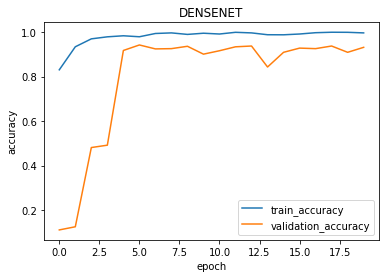

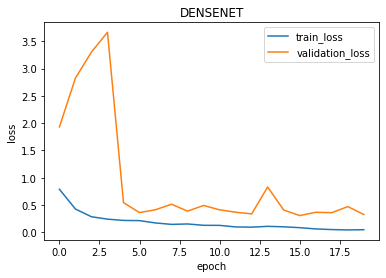

In [ ]:
plot_accuracy(history,'MOBILENET')
plot_loss(history,'MOBILENET')

In [ ]:
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n//1, verbose = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


241/241 [==============================] - 126s 523ms/step - loss: 1.1953 - accuracy: 0.7386
